# F20AA Coursework 1

## Step A: Data Collection

### Extracting Tweets from Twitter API

In [ ]:
!pip install git+https://github.com/tweepy/tweepy.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tweepy/tweepy.git to /tmp/pip-req-build-ncgdr307
  Running command git clone --filter=blob:none --quiet https://github.com/tweepy/tweepy.git /tmp/pip-req-build-ncgdr307
  Resolved https://github.com/tweepy/tweepy.git to commit 6fde20d61fd21b06408dedc38f542987cf91c1bc
  Preparing metadata (setup.py) ... done


In [ ]:
# utilities
import tweepy
import numpy as np
import pandas as pd
pd.set_option('max_colwidth',150)
import re
import string

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# Twitter API tokens and keys
API_KEY = 'xOgwbIZIOJqNV3cRnxA4NeB37'
API_KEY_SECRET = '958oKwNMtvm79OR7jIwoHamJ0thuITejGlznlDlRM3u6O6YIaY'
BEARER_TOKEN = 'AAAAAAAAAAAAAAAAAAAAAMqzlgEAAAAAppxxlV4Ej9W%2F2xQbVLCP7H5iemg%3D1Kz9dDPK4d5Pmrw5FIiKk9vtKaoqmGg6CtmrHFFca3ZpmIwbLD'
ACCESS_TOKEN = '1620646549695991808-ua6vKesnFHDdnmhlyWAGjY6PkeLSoV'
ACCESS_TOKEN_SECRET = 'uVJBmYCOyAIWYHU2OMtkFBWXP0zns4BksqAFRTXlukzVL'

In [ ]:
# client for connecting to the Twitter API
client = tweepy.Client(
    bearer_token = BEARER_TOKEN
)

# query to specify what tweets are to be extracted
query = '(technology OR tech) UAE lang:en -is:retweet -is:reply \
-(job OR jobs OR hire) -(college OR colleges) -kid -retweet -(contact OR call) -homework'

# tweet texts are written into a list
text_data = []

for tweet in tweepy.Paginator(client.search_recent_tweets, query = query, max_results = 100).flatten(limit = 1000):
    data = {
        "tweet_text" : tweet.text,
    }
    text_data.append(data)

In [ ]:
# dataframe to store the tweets
df = pd.DataFrame(text_data)
df.head()

,tweet_text
0,Only paid users to appear on your #Twitter 'For You' feed from April 15: #ElonMusk https://t.co/l8MWI3lL9R #UAE #Dubai #DXB
1,UAE Rover Likely Won't Join Chinese Moon Mission Due to Decades-Old U.S. Trade Law\n#technology #technologynews #technews\nhttps://t.co/CJY623wwBh
2,"#MENA leads in #crypto adoption! Saudi Arabia, #UAE and Egypt see surge in digital payments &amp; trading, driven by tech-savvy population &amp; I..."
3,"UAE spending on digital technology to hit $20bn by 2026, https://t.co/O9McW6PWIK via @TheNationalNews"
4,"The #UAE Minister of Industry and Advanced Technology, Special Envoy for Climate Change and President-Designate of #COP28, Sultan Al-Jaber, met wi..."


In [ ]:
print(df.shape)

(433, 1)


In [ ]:
# drop duplicates and reset the index
df = df.drop_duplicates(subset=['tweet_text'], keep='first')
df = df.reset_index(drop=True)

print(df.shape)

(389, 1)


In [ ]:
# save to csv file
# df.to_csv('tweets-feb-26.csv', index=False)

---

## Step B: Data Labelling

### Data Cleaning

#### Downloading Saved Tweets

Tweets were pulled and saved into a CSV file for further use.
These are then loaded for analysis.

In [ ]:
# Download dataset
!wget https://docs.google.com/spreadsheets/d/1Tc6k8jOHIT1rvRQhynkcAHjmGSVXqRlzAzYKa-FbvUw/export?format=csv -O tweets-feb-26.csv

--2023-03-28 20:19:07--  https://docs.google.com/spreadsheets/d/1Tc6k8jOHIT1rvRQhynkcAHjmGSVXqRlzAzYKa-FbvUw/export?format=csv
Resolving docs.google.com (docs.google.com)... 108.177.97.100, 108.177.97.139, 108.177.97.102, ...
Connecting to docs.google.com (docs.google.com)|108.177.97.100|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://doc-0s-8g-sheets.googleusercontent.com/export/r6backulg5lnalo18mkmp7tf28/98p9bttv4pjl60cdeqagceln28/1680034745000/101374743312247513623/*/1Tc6k8jOHIT1rvRQhynkcAHjmGSVXqRlzAzYKa-FbvUw?format=csv [following]
--2023-03-28 20:19:07--  https://doc-0s-8g-sheets.googleusercontent.com/export/r6backulg5lnalo18mkmp7tf28/98p9bttv4pjl60cdeqagceln28/1680034745000/101374743312247513623/*/1Tc6k8jOHIT1rvRQhynkcAHjmGSVXqRlzAzYKa-FbvUw?format=csv
Resolving doc-0s-8g-sheets.googleusercontent.com (doc-0s-8g-sheets.googleusercontent.com)... 74.125.204.132, 2404:6800:4008:c04::84
Connecting to doc-0s-8g-sheets.googleuserconte

In [ ]:
# read CSV file into a dataframe
df = pd.read_csv('tweets-feb-26.csv')

df.head()

,tweet_text
0,"""UAE’s Ministry of Defense announced it will sign with China’s National Aero-Technology Import and Export Corporation (CATIC) to buy 12 L-15 aircr..."
1,Sultan Al Jaber's recent visit to India to promote clean energy and decarbonization technology is a powerful example of the UAE's commitment to co...
2,"Nine Chinese arms manufacturers took part in the 16th International Defense Exhibition and Conference, a military technology expo in the United Ar..."
3,🧵1/3\n\nMeet @VenomFoundation The first fully regulated blockchain within the UAE 🔥\n\n$VENOM is a decentralized platform enabled by blockchain te...
4,"#CyFyFlashback\n\nThere are multiple possible areas for cooperation between #IndiaUAE, especially in the field of #tech.\n\nSamir Saran in convers..."


In [ ]:
print(df.shape)

(733, 1)


#### Cleaning the Tweets before Sentiment Analysis

In [ ]:
# function to clean tweets before analysing their sentiment
def clean_tweets1(tweet):
    tweet = re.sub('\n', ' ', tweet)              # remove newline character
    tweet = re.sub("RT @[A-Za-z0-9]*:","",tweet)  # remove retweet and username
    tweet = re.sub('@[A-Za-z0-9]+', '', tweet)    # remove username
    tweet = re.sub('\w+:\/\/\S+', '', tweet)      # remove hyperlink
    tweet = re.sub('&amp;', '&', tweet)           # replace with '&' character
    tweet = ' '.join(tweet.split())
    return tweet

clean1 = lambda x: clean_tweets1(x)

In [ ]:
# apply the function to clean the tweets
df_clean = pd.DataFrame(df.tweet_text.apply(clean1))

df_clean.head()

,tweet_text
0,"""UAE’s Ministry of Defense announced it will sign with China’s National Aero-Technology Import and Export Corporation (CATIC) to buy 12 L-15 aircr..."
1,Sultan Al Jaber's recent visit to India to promote clean energy and decarbonization technology is a powerful example of the UAE's commitment to co...
2,"Nine Chinese arms manufacturers took part in the 16th International Defense Exhibition and Conference, a military technology expo in the United Ar..."
3,🧵1/3 Meet The first fully regulated blockchain within the UAE 🔥 $VENOM is a decentralized platform enabled by blockchain technology that allows us...
4,"#CyFyFlashback There are multiple possible areas for cooperation between #IndiaUAE, especially in the field of #tech. Samir Saran in conversation ..."


In [ ]:
# drop duplicates again and reset the index
df_clean = df_clean.drop_duplicates(subset=['tweet_text'], keep='first')
df_clean = df_clean.reset_index(drop=True)

print(df_clean.shape)

(555, 1)


In [ ]:
# replace empty strings with nan and drop them
df_clean = df_clean.replace(to_replace='', value=np.nan)
df_clean = df_clean.dropna()

print(df_clean.shape)

(555, 1)


### Data Labelling with VADER

VADER (Valence Aware Dictionary for
sEntiment Reasoning) was chosen as the tool analysing the sentiment of the tweets and labelling them into positive, negative, and neutral.

VADER is seen to be the best option for analysing the sentiments of tweets. This is because of its sentiment lexicon that is particularly tuned to tweets and types of microblog texts, and also its ability to analyse the intensity of the sentiment using rules that represent grammar and syntax norms that humans use often (Hutto and Gilbert, 2014).

VADER can also analyse the sentiment from emoticons and word abbreviations that are used in tweets often.

In [ ]:
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 KB 3.2 MB/s eta 0:00:00


In [ ]:
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
# initialize the sentiment analyser
sia = SentimentIntensityAnalyzer()

# function to get the polairty of the tweets
vader_sentiment = lambda x: sia.polarity_scores(x)['compound']

df_clean['polarity_score'] = df_clean['tweet_text'].apply(vader_sentiment)

This gets the polarity of the tweet.
Returns a number between -1 and 1.

In [ ]:
df_clean.head()

,tweet_text,polarity_score
0,"""UAE’s Ministry of Defense announced it will sign with China’s National Aero-Technology Import and Export Corporation (CATIC) to buy 12 L-15 aircr...",0.1280
1,Sultan Al Jaber's recent visit to India to promote clean energy and decarbonization technology is a powerful example of the UAE's commitment to co...,0.8957
2,"Nine Chinese arms manufacturers took part in the 16th International Defense Exhibition and Conference, a military technology expo in the United Ar...",0.5106
3,🧵1/3 Meet The first fully regulated blockchain within the UAE 🔥 $VENOM is a decentralized platform enabled by blockchain technology that allows us...,0.8555
4,"#CyFyFlashback There are multiple possible areas for cooperation between #IndiaUAE, especially in the field of #tech. Samir Saran in conversation ...",0.0000


#### Getting the Sentiments of Tweets

In [ ]:
# loop through the dataframe and assign a sentiment label to each tweet
sentiments = []
for i in range(0, len(df_clean)):
    if df_clean.iloc[i]['polarity_score'] >= 0.05:
        sentiments.append('positive')
    elif df_clean.iloc[i]['polarity_score'] <= -0.05:
        sentiments.append('negative')
    else:
        sentiments.append('neutral')

df_clean['sentiment'] = sentiments

df_clean.head()

,tweet_text,polarity_score,sentiment
0,"""UAE’s Ministry of Defense announced it will sign with China’s National Aero-Technology Import and Export Corporation (CATIC) to buy 12 L-15 aircr...",0.1280,positive
1,Sultan Al Jaber's recent visit to India to promote clean energy and decarbonization technology is a powerful example of the UAE's commitment to co...,0.8957,positive
2,"Nine Chinese arms manufacturers took part in the 16th International Defense Exhibition and Conference, a military technology expo in the United Ar...",0.5106,positive
3,🧵1/3 Meet The first fully regulated blockchain within the UAE 🔥 $VENOM is a decentralized platform enabled by blockchain technology that allows us...,0.8555,positive
4,"#CyFyFlashback There are multiple possible areas for cooperation between #IndiaUAE, especially in the field of #tech. Samir Saran in conversation ...",0.0000,neutral


In [ ]:
print(df_clean.shape)

(555, 3)


In [ ]:
df_clean = df_clean.drop(['polarity_score'], axis=1)

df_clean.head()

,tweet_text,sentiment
0,"""UAE’s Ministry of Defense announced it will sign with China’s National Aero-Technology Import and Export Corporation (CATIC) to buy 12 L-15 aircr...",positive
1,Sultan Al Jaber's recent visit to India to promote clean energy and decarbonization technology is a powerful example of the UAE's commitment to co...,positive
2,"Nine Chinese arms manufacturers took part in the 16th International Defense Exhibition and Conference, a military technology expo in the United Ar...",positive
3,🧵1/3 Meet The first fully regulated blockchain within the UAE 🔥 $VENOM is a decentralized platform enabled by blockchain technology that allows us...,positive
4,"#CyFyFlashback There are multiple possible areas for cooperation between #IndiaUAE, especially in the field of #tech. Samir Saran in conversation ...",neutral


In [ ]:
# get the counts of tweets by sentiment
pd.DataFrame(df_clean['sentiment'].value_counts())

,sentiment
positive,392
neutral,122
negative,41


We can see from above that the dataset is skewed or imbalanced.

---

## Step C: Text Analytics Pipeline on Tweets

### Cleaning the Tweets before Analysis

#### Data Cleaning Steps

In [ ]:
# function to clean tweets before analysing their sentiment
def clean_tweets2(tweet):
    tweet = tweet.lower()                        # set all characters to lowercase
    tweet = re.sub('\w*\d\w*', '', tweet)        # remove digits and words with digits
    tweet = re.sub('[^0-9A-Za-z \t]', '', tweet) # remove special characters
    tweet = ' '.join(tweet.split())
    return tweet

clean2 = lambda x: clean_tweets2(x)

In [ ]:
df_clean['tweet_text'] = list(df_clean.tweet_text.apply(clean2))

df_clean.head()

,tweet_text,sentiment
0,uaes ministry of defense announced it will sign with chinas national aerotechnology import and export corporation catic to buy l aircraft with the...,positive
1,sultan al jabers recent visit to india to promote clean energy and decarbonization technology is a powerful example of the uaes commitment to comb...,positive
2,nine chinese arms manufacturers took part in the international defense exhibition and conference a military technology expo in the united arab emi...,positive
3,meet the first fully regulated blockchain within the uae venom is a decentralized platform enabled by blockchain technology that allows users to c...,positive
4,cyfyflashback there are multiple possible areas for cooperation between indiauae especially in the field of tech samir saran in conversation with ...,neutral


In [ ]:
# drop duplicates again
df_clean = df_clean.drop_duplicates(subset=['tweet_text'], keep='first')

df_clean = df_clean.reset_index(drop=True)

print(df_clean.shape)

(547, 2)


In [ ]:
# downloads for performing lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

#### Lemmatization

Lemmatization involves reducing a word to its base or dictionary form. It is useful in text classification, sentiment analysis, and information retrieval, as it helps to reduce the complexity of text and improve accuracy.

In [ ]:
from nltk.stem import WordNetLemmatizer

# lemmatization
tweets = list(df_clean['tweet_text'])

# initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

lem_tweets = []
for tweet in tweets:
    lemmatized_tweet = ''
    for word in tweet.split():
        word = lemmatizer.lemmatize(word)
        lemmatized_tweet = lemmatized_tweet + word + ' '
    lem_tweets.append(lemmatized_tweet)

In [ ]:
df_clean['tweet_text'] = lem_tweets
df_clean.head()

,tweet_text,sentiment
0,uaes ministry of defense announced it will sign with china national aerotechnology import and export corporation catic to buy l aircraft with the ...,positive
1,sultan al jabers recent visit to india to promote clean energy and decarbonization technology is a powerful example of the uaes commitment to comb...,positive
2,nine chinese arm manufacturer took part in the international defense exhibition and conference a military technology expo in the united arab emira...,positive
3,meet the first fully regulated blockchain within the uae venom is a decentralized platform enabled by blockchain technology that allows user to co...,positive
4,cyfyflashback there are multiple possible area for cooperation between indiauae especially in the field of tech samir saran in conversation with o...,neutral


In [ ]:
df2 = df_clean.copy()
df2.head()

,tweet_text,sentiment
0,uaes ministry of defense announced it will sign with china national aerotechnology import and export corporation catic to buy l aircraft with the ...,positive
1,sultan al jabers recent visit to india to promote clean energy and decarbonization technology is a powerful example of the uaes commitment to comb...,positive
2,nine chinese arm manufacturer took part in the international defense exhibition and conference a military technology expo in the united arab emira...,positive
3,meet the first fully regulated blockchain within the uae venom is a decentralized platform enabled by blockchain technology that allows user to co...,positive
4,cyfyflashback there are multiple possible area for cooperation between indiauae especially in the field of tech samir saran in conversation with o...,neutral


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [ ]:
df2['sentiment'] = df2['sentiment'].replace('positive', 2)
df2['sentiment'] = df2['sentiment'].replace('neutral', 1)
df2['sentiment'] = df2['sentiment'].replace('negative', 0)

Encoding the sentiment column for text analytics to train the models.

### Stratified KFold Cross Validation

To evaluate the performance of the classifiers, stratified k fold cross validation is used as the dataset is imbalanced.


The classifiers that are analysed here are:
- Support Vector Machine
- K Nearest Neighbors
- Multinomial Naive Bayes
- Logistic Regression

The comparison between CountVectorizer and TfidfVectorizer are also done to see which better represents the dataset.

In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold

#### Cross Validation with Count Vectorizer

By using cross-validation with Count Vectorizer, we can get a more accurate and reliable estimate of the performance of a machine learning model on a text classification task, and avoid overfitting to the training data.

In [ ]:
X = list(df2['tweet_text'])
y = list(df2['sentiment']) #dataset is split into train and test

vec = CountVectorizer(stop_words='english', ngram_range=(1,1)) # Instantiate the Count Vectorizer with the desired parameters, such as the range of n-grams to consider and use the stop word.
X = vec.fit_transform(X)   #Fit the Count Vectorizer on the training set to obtain the feature vectors.

crossval = StratifiedKFold(n_splits=10)

models = {                      #Use the feature vectors to train a machine learning model, such as a logistic regression, support vector machine, KNN and MultinomialNB.
    'SVC' : SVC(kernel='linear', random_state=42),
    'KNN' :KNeighborsClassifier(n_neighbors=5),
    'MultinomialNB' : MultinomialNB(),
    'LogisticRegression' : LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
}

print("Mean Accuracies Stratified KFold Cross-Validation")
for name, model in models.items():
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=crossval, n_jobs=-1)    #Evaluate the performance of the model on the test set using metrics such as accuracy, precision.
    print(f"{name} Mean Accuracy: {np.mean(scores)}")

Mean Accuracies Stratified KFold Cross-Validation
SVC Mean Accuracy: 0.7527946127946128
KNN Mean Accuracy: 0.41666666666666663
MultinomialNB Mean Accuracy: 0.7050841750841751
LogisticRegression Mean Accuracy: 0.7620875420875421


#### Cross Validation with Tfidf Vectorizer

When working with text data, one common approach is to use the Tfidf Vectorizer for feature extraction, which converts the text into a numerical representation based on the frequency of each word and the inverse document frequency.
Using Tfidf Vectorizer for feature extraction can help to capture the importance of each word in the text, and avoid giving too much weight to frequently occurring but less informative words, which can improve the model's performance.

In [ ]:
X = list(df2['tweet_text'])             #Split the dataset into training and test sets.
y = list(df2['sentiment'])

vec = TfidfVectorizer(stop_words='english', ngram_range=(1,1))  #ngram_range is the range of number of words in a sequence
X = vec.fit_transform(X)                #Instantiate the Tfidf Vectorizer with the desired parameters.

crossval = StratifiedKFold(n_splits=10)

models = {
    'SVC' : SVC(kernel='linear', random_state=42),
    'KNN' :KNeighborsClassifier(n_neighbors=5),
    'MultinomialNB' : MultinomialNB(),
    'LogisticRegression' : LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
}

print("Mean Accuracies Stratified KFold Cross-Validation")
for name, model in models.items():
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=crossval, n_jobs=-1)
    print(f"{name} Mean Accuracy: {np.mean(scores)}")

Mean Accuracies Stratified KFold Cross-Validation
SVC Mean Accuracy: 0.7603703703703705
KNN Mean Accuracy: 0.7326599326599327
MultinomialNB Mean Accuracy: 0.7257912457912458
LogisticRegression Mean Accuracy: 0.7331313131313132


TF-IDF indicates what the importance of the word is in order to understand the document or dataset.
TF-IDF Vectoriser converts a collection of raw documents to a matrix of TF-IDF features. The Vectoriser is usually trained on only the X_train dataset.

#### Stratified KFold Cross-Validation Summary Table

In [ ]:
summary3 = {          #Compute the average performance and the standard deviation across the different folds of the cross-validation.
    'Classifier' : [
        'Support Vector Machine', 'K-Nearest Neighbors', 'Multinomial Naive Bayes', 'Logistic Regression',
        'Support Vector Machine', 'K-Nearest Neighbors', 'Multinomial Naive Bayes', 'Logistic Regression'
    ],
    'Vectorizer' : [
        'CountVectorizer', 'CountVectorizer', 'CountVectorizer', 'CountVectorizer',
        'TfidfVectorizer', 'TfidfVectorizer', 'TfidfVectorizer', 'TfidfVectorizer',
    ],
    'Accuracy Score' : [0.752, 0.416, 0.705, 0.762, 0.760, 0.732, 0.725, 0.733],
}

kfold_summary = pd.DataFrame(data=summary3)

kfold_summary

,Classifier,Vectorizer,Accuracy Score
0,Support Vector Machine,CountVectorizer,0.752
1,K-Nearest Neighbors,CountVectorizer,0.416
2,Multinomial Naive Bayes,CountVectorizer,0.705
3,Logistic Regression,CountVectorizer,0.762
4,Support Vector Machine,TfidfVectorizer,0.760
5,K-Nearest Neighbors,TfidfVectorizer,0.732
6,Multinomial Naive Bayes,TfidfVectorizer,0.725
7,Logistic Regression,TfidfVectorizer,0.733


From the table above, it is shown that the TfidfVectorizer was better overall for representing the data for classification.

### Hyperparameter tuning with Grid Search

A Grid Search is done to find the best hyperparameters for each classifier and vectorizer that brings the best score.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [ ]:
X = list(df2['tweet_text'])
y = list(df2['sentiment'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

models = {
    'SVC' : SVC(kernel='linear', random_state=42),
    'KNN' :KNeighborsClassifier(),
    'MultinomialNB' : MultinomialNB(),
    'LogisticRegression' : LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42)
}

parameters_dict = {
    'SVC' : [{
        'vect__ngram_range': [(1, 1), (1, 2), (2, 2), (3, 3)],
        'vect__min_df': [1, 2, 3, 4, 5],
        'clf__C': [0.001, 0.01, 0.1, 1, 10],
        'clf__kernel' : ['linear', 'poly', 'rbf']
    }],
    'KNN' : [{
        'vect__ngram_range': [(1, 1), (1, 2), (2, 2), (3, 3)],
        'vect__min_df': [1, 2, 3, 4, 5],
        'clf__n_neighbors': [3, 4, 5, 6, 7],
    }],
    'MultinomialNB': [{
        'vect__ngram_range': [(1, 1), (1, 2), (2, 2), (3, 3)],
        'vect__min_df': [1, 2, 3, 4, 5],
        'clf__alpha': [0.001, 0.01, 0.1, 1, 10],
    }],
    'LogisticRegression' : [{
        'vect__ngram_range': [(1, 1), (1, 2), (2, 2), (3, 3)],
        'vect__min_df': [1, 2, 3, 4, 5],
        'clf__C': [0.001, 0.01, 0.1, 1, 10],
    }]
}

vects = {
    'Count' : CountVectorizer(),
    'Tfidf' : TfidfVectorizer()
}

#### Vectorizers and Classifiers Grid Search

---




Grid search is a hyperparameter tuning technique used in machine learning to systematically search through a range of possible hyperparameters for a given model to find the optimal set of hyperparameters that produces the best performance.

In [ ]:
for vect_name, vect in vects.items():
  for model_name, model in models.items():
    pipe = Pipeline([
      ('vect', vect),
      ('clf', model),
    ])

    parameters = parameters_dict[model_name]

    grid = GridSearchCV(pipe, parameters, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)

    print(f"{vect_name} Vectorizer and {model_name} Classifier Grid Search:")
    print(f"Best cross-validation score: {grid.best_score_}")
    print(f"Best parameters: {grid.best_params_}")
    print(f"Test score: {grid.score(X_test, y_test)}")
    print()

Count Vectorizer and SVC Classifier Grid Search:
Best cross-validation score: 0.7758098223615464
Best parameters: {'clf__C': 1, 'clf__kernel': 'linear', 'vect__min_df': 1, 'vect__ngram_range': (2, 2)}
Test score: 0.8090909090909091

Count Vectorizer and KNN Classifier Grid Search:
Best cross-validation score: 0.7093521421107628
Best parameters: {'clf__n_neighbors': 5, 'vect__min_df': 2, 'vect__ngram_range': (3, 3)}
Test score: 0.509090909090909

Count Vectorizer and MultinomialNB Classifier Grid Search:
Best cross-validation score: 0.7894200626959247
Best parameters: {'clf__alpha': 0.001, 'vect__min_df': 2, 'vect__ngram_range': (1, 2)}
Test score: 0.7818181818181819

Count Vectorizer and LogisticRegression Classifier Grid Search:
Best cross-validation score: 0.7735893416927899
Best parameters: {'clf__C': 10, 'vect__min_df': 1, 'vect__ngram_range': (1, 2)}
Test score: 0.8090909090909091

Tfidf Vectorizer and SVC Classifier Grid Search:
Best cross-validation score: 0.7826541274817137
Bes

By performing a grid search for vectorizers and classifiers, the best combination of hyperparameters that produces the best performance for a given text classification task, and avoid manually tuning the hyperparameters, which can be time-consuming and error-prone. This helps to improve the accuracy and robustness of the machine learning model.

#### Summary Table of Grid Search

In [ ]:
summary2 = {
    'Classifier' : [
        'Support Vector Machine', 'K-Nearest Neighbors', 'Multinomial Naive Bayes', 'Logistic Regression',
        'Support Vector Machine', 'K-Nearest Neighbors', 'Multinomial Naive Bayes', 'Logistic Regression'
    ],
    'Vectorizer' : [
        'CountVectorizer', 'CountVectorizer', 'CountVectorizer', 'CountVectorizer',
        'TfidfVectorizer', 'TfidfVectorizer', 'TfidfVectorizer', 'TfidfVectorizer',
    ],
    'Best Score' : [0.775, 0.709, 0.789, 0.773, 0.782, 0.773, 0.787, 0.775],
    'Test Score' : [0.809, 0.509, 0.781, 0.809, 0.827, 0.772, 0.781, 0.809],
    'Best Parameters' : [
        {'clf__C': 1, 'clf__kernel': 'linear', 'vect__min_df': 1, 'vect__ngram_range': (2, 2)},
        {'clf__n_neighbors': 5, 'vect__min_df': 2, 'vect__ngram_range': (3, 3)},
        {'clf__alpha': 0.001, 'vect__min_df': 2, 'vect__ngram_range': (1, 2)},
        {'clf__C': 10, 'vect__min_df': 1, 'vect__ngram_range': (1, 2)},
        {'clf__C': 10, 'clf__kernel': 'rbf', 'vect__min_df': 2, 'vect__ngram_range': (1, 1)},
        {'clf__n_neighbors': 5, 'vect__min_df': 2, 'vect__ngram_range': (1, 1)},
        {'clf__alpha': 0.01, 'vect__min_df': 2, 'vect__ngram_range': (1, 2)},
        {'clf__C': 10, 'vect__min_df': 1, 'vect__ngram_range': (1, 1)}
    ]
}

grid_search_summary = pd.DataFrame(data=summary2)

grid_search_summary

,Classifier,Vectorizer,Best Score,Test Score,Best Parameters
0,Support Vector Machine,CountVectorizer,0.775,0.809,"{'clf__C': 1, 'clf__kernel': 'linear', 'vect__min_df': 1, 'vect__ngram_range': (2, 2)}"
1,K-Nearest Neighbors,CountVectorizer,0.709,0.509,"{'clf__n_neighbors': 5, 'vect__min_df': 2, 'vect__ngram_range': (3, 3)}"
2,Multinomial Naive Bayes,CountVectorizer,0.789,0.781,"{'clf__alpha': 0.001, 'vect__min_df': 2, 'vect__ngram_range': (1, 2)}"
3,Logistic Regression,CountVectorizer,0.773,0.809,"{'clf__C': 10, 'vect__min_df': 1, 'vect__ngram_range': (1, 2)}"
4,Support Vector Machine,TfidfVectorizer,0.782,0.827,"{'clf__C': 10, 'clf__kernel': 'rbf', 'vect__min_df': 2, 'vect__ngram_range': (1, 1)}"
5,K-Nearest Neighbors,TfidfVectorizer,0.773,0.772,"{'clf__n_neighbors': 5, 'vect__min_df': 2, 'vect__ngram_range': (1, 1)}"
6,Multinomial Naive Bayes,TfidfVectorizer,0.787,0.781,"{'clf__alpha': 0.01, 'vect__min_df': 2, 'vect__ngram_range': (1, 2)}"
7,Logistic Regression,TfidfVectorizer,0.775,0.809,"{'clf__C': 10, 'vect__min_df': 1, 'vect__ngram_range': (1, 1)}"


From the table above, the following observations are made:
- Classifiers using TfidfVectorizer had better scores.
- The K-Nearest Neighbors classifier had the lowest scores.
- The Support Vector Machine and Logistic Regression classifiers had similar scores and were the best.

### Best Models Performance Analysis

The four classifiers are built with their best hyperparameters to analyse their performance using their precision and recall scores.

In [ ]:
X = list(df2['tweet_text'])
y = list(df2['sentiment'])

# split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# function to get the prediction evaluation for each classifier
def get_prediction_score(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Classification Report of Classifier")
    print(classification_report(y_test, y_pred, zero_division=0))
    print()
    cfm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix of Classifier")
    sns.heatmap(cfm, annot=True, fmt='g', cmap='Purples')

#### Support Vector Machine Classifier

support vector machine (SVM) classifier is a type of machine learning algorithm that can be used for classification and regression analysis. The main idea behind SVMs is to find the hyperplane that best separates the data points of different classes in a feature space.

Classification Report of Classifier
              precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.90      0.38      0.53        24
           2       0.82      0.99      0.89        81

    accuracy                           0.82       110
   macro avg       0.74      0.52      0.57       110
weighted avg       0.82      0.82      0.79       110


Confusion Matrix of Classifier


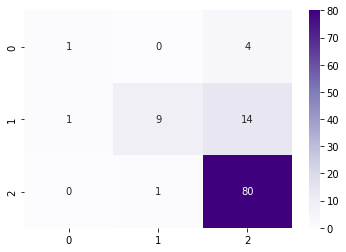

In [ ]:
svc_pipe = Pipeline([
      ('vect', TfidfVectorizer(stop_words='english', ngram_range=(1,1), min_df=2)),
      ('clf', SVC(C=10, kernel='rbf', random_state=42)),
    ])

get_prediction_score(svc_pipe)

#### K-Nearest Neighbor Classifier

KNN is a non-parametric algorithm, meaning it does not make any assumptions about the underlying distribution of the data.

The basic idea behind KNN is to classify a data point based on the class of its k nearest neighbors in a feature space. The value of k is a hyperparameter that needs to be specified by the user

confusion matrix was used to get a clear and concise summary of the classification results, which can be used to calculate a range of performance metrics and compare the performance of different models.


Classification Report of Classifier
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.58      0.46      0.51        24
           2       0.82      0.88      0.85        81

    accuracy                           0.75       110
   macro avg       0.47      0.44      0.45       110
weighted avg       0.73      0.75      0.73       110


Confusion Matrix of Classifier


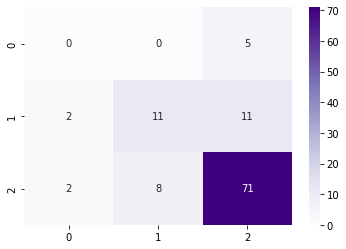

In [ ]:
knn_pipe = Pipeline([
      ('vect', TfidfVectorizer(stop_words='english', ngram_range=(1,1), min_df=2)),
      ('clf', KNeighborsClassifier(n_neighbors=5)),
    ])

get_prediction_score(knn_pipe)

#### Multinomial Naive Bayes Classifier

 It is based on the Bayes theorem of probability, which calculates the probability of a hypothesis given the evidence.

Classification Report of Classifier
              precision    recall  f1-score   support

           0       0.33      0.40      0.36         5
           1       0.71      0.42      0.53        24
           2       0.84      0.94      0.89        81

    accuracy                           0.80       110
   macro avg       0.63      0.58      0.59       110
weighted avg       0.79      0.80      0.79       110


Confusion Matrix of Classifier


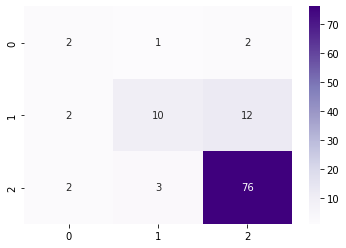

In [ ]:
naive_bayes_pipe = Pipeline([
      ('vect', TfidfVectorizer(stop_words='english', ngram_range=(1,2), min_df=2)),
      ('clf', MultinomialNB(alpha=0.01)),
    ])

get_prediction_score(naive_bayes_pipe)

#### Logistic Regression Classifier

The logistic regression model is based on the logistic function, which maps any input value to a probability value between 0 and 1.

Classification Report of Classifier
              precision    recall  f1-score   support

           0       0.33      0.20      0.25         5
           1       0.82      0.38      0.51        24
           2       0.81      0.96      0.88        81

    accuracy                           0.80       110
   macro avg       0.65      0.51      0.55       110
weighted avg       0.79      0.80      0.77       110


Confusion Matrix of Classifier


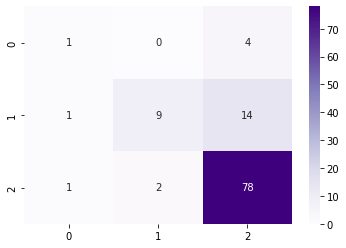

In [ ]:
lr_pipe = Pipeline([
      ('vect', TfidfVectorizer(stop_words='english', ngram_range=(1,1), min_df=1)),
      ('clf', LogisticRegression(C=10, multi_class='multinomial', solver='lbfgs', random_state=42)),
    ])

get_prediction_score(lr_pipe)

#### Models Performance Summary Table

In [ ]:
summary4 = {
    'Classifier' : [
        'Support Vector Machine', 'K-Nearest Neighbors', 'Multinomial Naive Bayes', 'Logistic Regression',
    ],
    'Accuracy Score' : [0.82, 0.75, 0.80, 0.80],
    'Precision Macro Average' : [0.74, 0.47, 0.63, 0.65],
    'Recall Macro Average' : [0.52, 0.44, 0.58, 0.51],
}

models_summary = pd.DataFrame(data=summary4)

models_summary

,Classifier,Accuracy Score,Precision Macro Average,Recall Macro Average
0,Support Vector Machine,0.82,0.74,0.52
1,K-Nearest Neighbors,0.75,0.47,0.44
2,Multinomial Naive Bayes,0.80,0.63,0.58
3,Logistic Regression,0.80,0.65,0.51


The macro average was used to calculate the precision and recall for each classifier. This is the average calculated from the performance of the individual classes.

From the above table, the following observations are made:
- Support Vector Machine classifier had the highest precision score.
- Multinomial Naive Bayes and Logistic Regression classifiers had similar precision and recall scores, with Multinomial Naive Bayes having the highest recall score.
- K-Nearest Neighbors classifier had the lowest precision and recall scores.

---

## Step D: Visualization and Insights From Tweets

### Analysis of the Tweets Overall

In [ ]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 19.0 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.2.0 which is incompatible.


In [ ]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from sklearn.decomposition import LatentDirichletAllocation

import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()

In [ ]:
df3 = df_clean.copy()
df3.head()

,tweet_text,sentiment
0,uaes ministry of defense announced it will sign with china national aerotechnology import and export corporation catic to buy l aircraft with the ...,positive
1,sultan al jabers recent visit to india to promote clean energy and decarbonization technology is a powerful example of the uaes commitment to comb...,positive
2,nine chinese arm manufacturer took part in the international defense exhibition and conference a military technology expo in the united arab emira...,positive
3,meet the first fully regulated blockchain within the uae venom is a decentralized platform enabled by blockchain technology that allows user to co...,positive
4,cyfyflashback there are multiple possible area for cooperation between indiauae especially in the field of tech samir saran in conversation with o...,neutral


In [ ]:
print(df3.shape)

(547, 2)


#### Distribution of Tweets

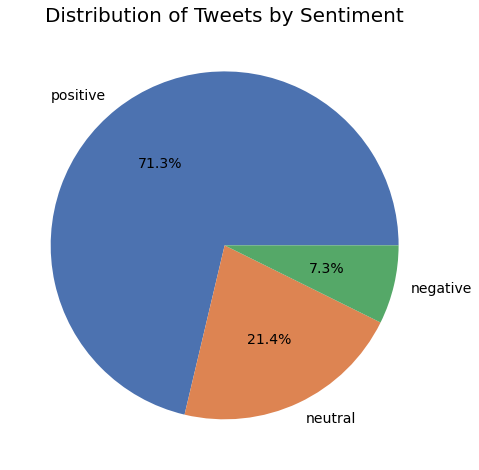

In [ ]:
# pie chart showing the tweets distribution
color_pal = sns.color_palette('deep')[0:3]
labels = list(df3['sentiment'].unique())

plt.figure(figsize=(20, 8))
plt.title('Distribution of Tweets by Sentiment', fontsize=20)
plt.pie(df3['sentiment'].value_counts(), labels=labels, colors=color_pal, autopct='%1.1f%%', textprops={'fontsize': 14})
plt.show()

It is made visible from the pie chart that the dataset is imbalanced with a large majority of positive tweets.

In [ ]:
c_vec = CountVectorizer(stop_words='english')
df_cv = c_vec.fit_transform(df3.tweet_text)

sum_words = df_cv.sum(axis=0)
feature_names = c_vec.get_feature_names_out()
word_frequency = zip(feature_names, sum_words.tolist()[0])
frequency_sorted = sorted(word_frequency, key=lambda x: -x[1])

df_word_counts = pd.DataFrame(frequency_sorted, columns=['Word', 'Count'])

df_word_counts.head(20)

,Word,Count
0,uae,530
1,technology,386
2,dubai,123
3,tech,107
4,business,80
5,ha,69
6,new,65
7,innovation,62
8,solution,59
9,industry,56


In [ ]:
# extra stop words for the word clouds
extra_stop_words = [
    'uae',
    'technology',
    'dubai',
    'tech',
    'ha',
    'new',
    'uaes',
    'idex',
    'al',
]

# add extra words to the stop words list
new_stop_words = ENGLISH_STOP_WORDS.union(extra_stop_words)

In [ ]:
# split the data set into three based on the sentiment
df_positive =  list(df3.loc[df3['sentiment'] == 'positive']['tweet_text'])
df_negative =  list(df3.loc[df3['sentiment'] == 'negative']['tweet_text'])
df_neutral =  list(df3.loc[df3['sentiment'] == 'neutral']['tweet_text'])

### Analysis of Tweets Under each Sentiment

Topic Modeling is done for tweets under each type of sentiment to see what kind of topics are discussed in them.

Word Clouds are created as well to display the most frequently occurring words in the tweets under each  sentiment.

#### Positive Tweets

##### Topic Modeling Visualization

In [ ]:
count_vect = CountVectorizer(stop_words=list(new_stop_words), ngram_range=(1, 1), max_features=10000, max_df=0.15)
count_vect_dtm = count_vect.fit_transform(df_positive)

lda_model = LatentDirichletAllocation(n_components=3, learning_method="batch", max_iter=25, random_state=0)

lda_matrix = lda_model.fit_transform(count_vect_dtm)

pyLDAvis.lda_model.prepare(lda_model, count_vect_dtm, count_vect)

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.061003  0.089379       1        1  37.040640
1     -0.113371  0.004657       2        1  31.480697
0      0.052368 -0.094035       3        1  31.478663, topic_info=             Term       Freq      Total Category  logprob  loglift
1195  information  17.000000  17.000000  Default  30.0000  30.0000
546   crunchdubai  13.000000  13.000000  Default  29.0000  29.0000
1462       member  15.000000  15.000000  Default  28.0000  28.0000
1977       salina  13.000000  13.000000  Default  27.0000  27.0000
1657          owl  13.000000  13.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
75             ai   4.949294  10.804599   Topic3  -6.0617   0.3751
2549        world   5.078161  13.687842   Topic3  -6.0360   0.1643
328      business   5.668096  41.934648   Topic3  -5.9261  -0.8454
2078         sign   5.014907  14.434299   Topic3  -6.0486   0.0987
43       advanced   4.983092  34.580461   Topic3  -6.0549  -0.7814

[210 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
7         1  0.315070       abu
7         2  0.126028       abu
7         3  0.567125       abu
8         1  0.308471  abudhabi
8         2  0.205647  abudhabi
...     ...       ...       ...
2549      3  0.365288     world
2565      3  0.700154       xrp
2566      3  0.700154  xrpbased
2573      1  0.837389      year
2573      3  0.157011      year

[265 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

##### Word Cloud Visualization

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


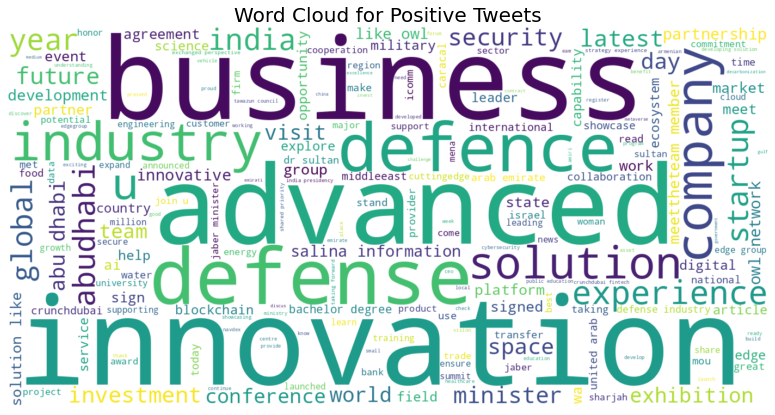

In [ ]:
wordcloud = WordCloud(random_state=42, stopwords=new_stop_words, background_color="white", width=1400, height=700).generate(' '.join(df_positive))
plt.figure(figsize=(14, 7))
plt.title('Word Cloud for Positive Tweets', fontsize=20)
plt.axis("off")
plt.imshow(wordcloud, interpolation='bilinear')

#### Negative Tweets

##### Topic Modeling Visualization

In [ ]:
count_vect = CountVectorizer(stop_words=list(new_stop_words), ngram_range=(1, 1), max_features=10000, max_df=0.15)
count_vect_dtm = count_vect.fit_transform(df_negative)

lda_model = LatentDirichletAllocation(n_components=3, learning_method="batch", max_iter=25, random_state=0)  # Create LDA object

lda_matrix = lda_model.fit_transform(count_vect_dtm)   ## Fit and Transform SVD model on data

pyLDAvis.lda_model.prepare(lda_model, count_vect_dtm, count_vect)  # this will create the visualizations for the topic clusters

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.107631 -0.036107       1        1  42.452340
2     -0.089510 -0.063603       2        1  31.863971
0     -0.018121  0.099710       3        1  25.683689, topic_info=              Term      Freq     Total Category  logprob  loglift
13              ai  3.000000  3.000000  Default  30.0000  30.0000
331      pathology  3.000000  3.000000  Default  29.0000  29.0000
68        business  2.000000  2.000000  Default  28.0000  28.0000
138          drone  3.000000  3.000000  Default  27.0000  27.0000
67        building  2.000000  2.000000  Default  26.0000  26.0000
..             ...       ...       ...      ...      ...      ...
228  international  0.693517  1.727419   Topic3  -5.5375   0.4467
476           view  0.693481  1.727427   Topic3  -5.5376   0.4466
261           like  0.693307  1.659374   Topic3  -5.5378   0.4866
356           race  0.693232  1.659380   Topic3  -5.5380   0.4865
156        emirate  0.693010  1.659401   Topic3  -5.5383   0.4861

[151 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2         2  0.586088         abu
3         1  0.807379    abudhabi
6         3  0.620109  accounting
7         2  0.586088     address
13        2  1.007127          ai
...     ...       ...         ...
493       2  0.880052     working
494       1  0.355511       world
494       2  0.355511       world
494       3  0.355511       world
497       2  0.586088      yousif

[155 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

##### Word Cloud Visualization

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


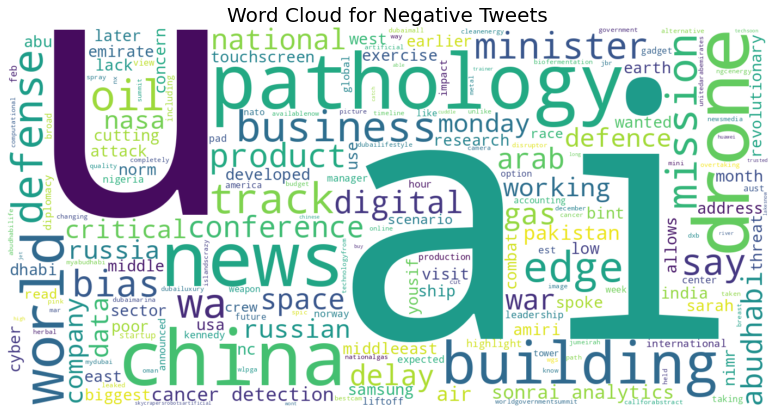

In [ ]:
wordcloud = WordCloud(random_state=42, stopwords=new_stop_words, background_color="white", width=1400, height=700).generate(' '.join(df_negative))
plt.figure(figsize=(14, 7))
plt.title('Word Cloud for Negative Tweets', fontsize=20)
plt.axis("off")
plt.imshow(wordcloud, interpolation='bilinear')

#### Neutral Tweets

##### Topic Modeling Visualization

In [ ]:
count_vect = CountVectorizer(stop_words=list(new_stop_words), ngram_range=(1, 1), max_features=10000, max_df=0.15)
count_vect_dtm = count_vect.fit_transform(df_neutral)

lda_model = LatentDirichletAllocation(n_components=3, learning_method="batch", max_iter=25, random_state=0)

lda_matrix = lda_model.fit_transform(count_vect_dtm)

pyLDAvis.lda_model.prepare(lda_model, count_vect_dtm, count_vect)

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.049783  0.093095       1        1  40.044321
1     -0.120295 -0.010113       2        1  37.227646
0      0.070512 -0.082981       3        1  22.728032, topic_info=              Term      Freq      Total Category  logprob  loglift
747          space  8.000000   8.000000  Default  30.0000  30.0000
65       astronaut  7.000000   7.000000  Default  29.0000  29.0000
189           crew  6.000000   6.000000  Default  28.0000  28.0000
568           nasa  5.000000   5.000000  Default  27.0000  27.0000
445  international  5.000000   5.000000  Default  26.0000  26.0000
..             ...       ...        ...      ...      ...      ...
121       business  1.781621  12.722074   Topic3  -5.2548  -0.4842
870        vehicle  1.259344   2.973762   Topic3  -5.6017   0.6223
598           open  1.256455   2.346725   Topic3  -5.6040   0.8568
860            usb  1.256083   2.346812   Topic3  -5.6043   0.8565
171        company  1.253022   3.667571   Topic3  -5.6068   0.4076

[171 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
2         1  0.692757       abu
2         3  0.230919       abu
3         1  0.452700  abudhabi
3         2  0.226350  abudhabi
3         3  0.226350  abudhabi
...     ...       ...       ...
896       2  0.785903      wifi
902       1  0.312062     world
902       2  0.624125     world
904       3  0.592578    yahsat
905       1  0.771117      year

[185 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

##### Word Cloud Visualization

/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


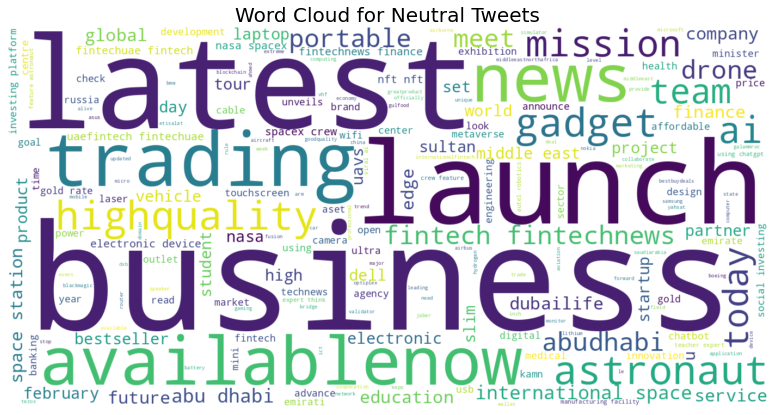

In [ ]:
wordcloud = WordCloud(random_state=42, stopwords=new_stop_words, background_color="white", width=1400, height=700).generate(' '.join(df_neutral))
plt.figure(figsize=(14, 7))
plt.title('Word Cloud for Neutral Tweets', fontsize=20)
plt.axis("off")
plt.imshow(wordcloud, interpolation='bilinear')

---

## Step E: Discussion and Conclusion

### Main Findings from Step A

- The topic for exctracting the tweets was "Technology in UAE".
- The tweets were searched and extracted from the last 7 days.
- There were a lot lot tweets regarding job offers homework help that were getting extracted. These were left out as it was not relevant to the topic.
- The tweets extracted were saved into a CSV file for analysis later.

### Main Findings from Step B

The tweets were preprocessed before labeling them. This involved removing usernames, hyperlinks, and new line characters from the tweets as they were not relevant for sentiment analysis.

The VADER sentiment analysis tool is effective for analysing texts such as tweets. The lexicon used by VADER is effective for analysing the text of tweets and VADER also has the ability to analyse the intensity of the sentiment. Analysing the sentiment of emoticons is also possible with VADER. The use of VADER to for the data labelling step was verified from (Hutto and Gilbert, 2014).

The main finding in this step is that the resulting dataset after performing the data labelling is skewed and imbalanced.

### Main Findings from Step C

**Text Preprocessing**\
The tweets were first preprocessed using the following steps:
- setting all the chracters in the text to lowercase
- removing digits and words containing digits from the text
- removing special characters and punctuation marks
- lemmatization was done to the text

Lemmatization was chosen for transforming words to their base form while keeping their meaning.

The CountVectorizer and TfidfVectorizer were considered and analysed for representing the data for classification.

The classifiers chosen for analysis and evaluation were the Support Vector Machine, K Nearest Neighbors, Multinomial Naive Bayes, and Logistic Regression models.

**Stratified K Fold Cross-Validation**\
Due to the imabalance in the dataset, Stratified K Fold Cross-Validation was done so that the accuracy of the classifiers could be better evaluated.

Stratified K Fold Cross-Validation was done for each of the model using the CountVectorizer and TfidfVectorizer.

The results of the cross-validation are given in the table below.

In [ ]:
kfold_summary

,Classifier,Vectorizer,Accuracy Score
0,Support Vector Machine,CountVectorizer,0.752
1,K-Nearest Neighbors,CountVectorizer,0.416
2,Multinomial Naive Bayes,CountVectorizer,0.705
3,Logistic Regression,CountVectorizer,0.762
4,Support Vector Machine,TfidfVectorizer,0.760
5,K-Nearest Neighbors,TfidfVectorizer,0.732
6,Multinomial Naive Bayes,TfidfVectorizer,0.725
7,Logistic Regression,TfidfVectorizer,0.733


From the table above, following observations are made:
- The classifiers using the TfidfVectorizer to represent the data had better scores.
- The Support Vector Machine classifier had the highest scores for both vectorizers, and Logistic Regression classifier was 2nd highest.
- The K Nearest Neighbors classifier had the lowest score of all with the CountVectorizer.

**Grid Search**\
A grid search was done to find the best hyperparameters that brought best classification results. The search was done for the hyperparameters for the two vectorizers for the four models, so a total 0f 8 grid searches were done.

The results are given below.

In [ ]:
grid_search_summary

,Classifier,Vectorizer,Best Score,Test Score,Best Parameters
0,Support Vector Machine,CountVectorizer,0.775,0.809,"{'clf__C': 1, 'clf__kernel': 'linear', 'vect__min_df': 1, 'vect__ngram_range': (2, 2)}"
1,K-Nearest Neighbors,CountVectorizer,0.709,0.509,"{'clf__n_neighbors': 5, 'vect__min_df': 2, 'vect__ngram_range': (3, 3)}"
2,Multinomial Naive Bayes,CountVectorizer,0.789,0.781,"{'clf__alpha': 0.001, 'vect__min_df': 2, 'vect__ngram_range': (1, 2)}"
3,Logistic Regression,CountVectorizer,0.773,0.809,"{'clf__C': 10, 'vect__min_df': 1, 'vect__ngram_range': (1, 2)}"
4,Support Vector Machine,TfidfVectorizer,0.782,0.827,"{'clf__C': 10, 'clf__kernel': 'rbf', 'vect__min_df': 2, 'vect__ngram_range': (1, 1)}"
5,K-Nearest Neighbors,TfidfVectorizer,0.773,0.772,"{'clf__n_neighbors': 5, 'vect__min_df': 2, 'vect__ngram_range': (1, 1)}"
6,Multinomial Naive Bayes,TfidfVectorizer,0.787,0.781,"{'clf__alpha': 0.01, 'vect__min_df': 2, 'vect__ngram_range': (1, 2)}"
7,Logistic Regression,TfidfVectorizer,0.775,0.809,"{'clf__C': 10, 'vect__min_df': 1, 'vect__ngram_range': (1, 1)}"


From the table above, these observations are made:
- The classifiers using the TfidfVectorizer had better scores than CountVectorizer.
- The K-Nearest Neighbors classifier had the lowest scores for both vectorizers.
- The Multinomial Naive Bayes classifier had similar scores for both vectorizers.
- The Support Vector Machine and Logistic Regression classifiers had similar scores and were the best overall.

**Best Models** \
Once the best hyperparameters are found, the four classifiers are built and trained using them. Their classification performance is then compared and evaluated using their precision and recall scores.

Since the TfidfVectorizer was shown to be better, it is used to build the models.

The macro average was used to calculate the precison and recall. This means that the precision and recall for each individual class was calculted and then the average was taken.

In [ ]:
models_summary

,Classifier,Accuracy Score,Precision Macro Average,Recall Macro Average
0,Support Vector Machine,0.82,0.74,0.52
1,K-Nearest Neighbors,0.75,0.47,0.44
2,Multinomial Naive Bayes,0.80,0.63,0.58
3,Logistic Regression,0.80,0.65,0.51


From the table given above, these are a few findings:
- The Support Vector Machine had the highest precision score of all the classifiers.
- The Support Vector Machine and Logistic Regression models had similar recall scores.
- THe Multinomial Naive Bayes and Logistic Regression classifiers had similar precision and recall scores, with Multinomial Naive Bayes having the highest recall score.
- The K-Nearest Neighbors classifier had the lowest precision and recall scores.

**Main Findings Overall** \
- The TfidfVectorizer represented the text data better than the CountVectorizer.
- The Support Vector Machine classifier had good results overall for the classsification.
- The Multinomial Naive Bayes and Logistic Regression had similar results for classification.
- The K-Nearest Neighbors model was unsuited for classification as it mostly had low scores when compared to the other models.

### Main Findings from Step D

In this section the tweets for each sentiment were analysed separately using visualizations.

Topic modeling was done to see what kind of topics were being mentioned or discussed for each sentiment. Three topics were pulled and these were visualized using pyLDAvis.

Word Clouds were created as well to see the frequently occurring words for each sentiment.

**Positive Tweets Findings** \
The top most relevant word in each topic from topic modeling were:
- solution
- business
- company

The word cloud revealed the top most frequently occurring words are:
- business
- advanced
- innovation
- defence


**Negative Tweets Findings** \
The top most relevant word in each topic from topic modeling were:
- oil
- ai
- drone

The word cloud revealed the top most frequently occurring words are:
- ai
- drone
- china
- pathology
- news

**Neutral Tweets Findings** \
The top most relevant word in each topic from topic modeling were:
- business
- space
- nft

The word cloud revealed the top most frequently occurring words are:
- latest
- launch
- business
- news

**Main Findings Overall** \
- The positive tweets were mostly related to business and company news about advanced and innovative solutions.
- The negative tweets were about news related to ai (artificial intelligence), drones, and china.
- The neutral tweets were about news regarding the latest launches business news.
- All tweets were related to business news.

### Summary of Findings

- The dataset was imbalanced with a large number of positive tweets and low number of negative tweets.
- The insights from the sentiment analysis of tweets for the topic "Technology in UAE" can be useful to understand what people in the UAE want with new and advancing technology.
- Businesses can create better products that suit the needs of the customers if they understand how they feel about the current technology in the market.
- Companies can make better profits if they can understand how people feel about their products and make better ones for the future.

## References

Balodi, T. (2020) What is Stemming and Lemmatization in NLP? | Analytics Steps. Available at: https://www.analyticssteps.com/blogs/what-stemming-and-lemmatization-nlp (Accessed: 10 March 2023).

Hutto, C. and Gilbert, E. (2014) ‘VADER: A Parsimonious Rule-Based Model for Sentiment Analysis of Social Media Text’, Proceedings of the International AAAI Conference on Web and Social Media, 8(1), pp. 216–225. Available at: https://doi.org/10.1609/icwsm.v8i1.14550.

Kaplan, D. (2022) Machine Learning 101: CountVectorizer Vs TFIDFVectorizer » EML. Available at: https://enjoymachinelearning.com/blog/countvectorizer-vs-tfidfvectorizer/ (Accessed: 10 March 2023).

Kapoor, N. (2021) NLP: Text Data Visualization, Numpy Ninja. Available at: https://www.numpyninja.com/post/nlp-text-data-visualization (Accessed: 10 March 2023).

Kirenz, J. (2022) Twitter API v2, tweepy and pandas in Python, Jan Kirenz. Available at: https://kirenz.com/post/2021-12-10-twitter-api-v2-tweepy-and-pandas-in-python/twitter-api-v2-tweepy-and-pandas-in-python/ (Accessed: 10 March 2023).

Kumar, N. (2017) ‘Twitter Sentiment Analysis using Python’, GeeksforGeeks, 24 January. Available at: https://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/ (Accessed: 10 March 2023).

Levine, Y. (2017) ‘How To Grid-Search With A Pipeline’, Medium, 8 September. Available at: https://medium.com/@yoni.levine/how-to-grid-search-with-a-pipeline-93147835d916 (Accessed: 10 March 2023).

Lyashenko, V. (2023) Cross-Validation in Machine Learning: How to Do It Right, neptune.ai. Available at: https://neptune.ai/blog/cross-validation-in-machine-learning-how-to-do-it-right (Accessed: 10 March 2023).

Navlani, A. (2021) ‘Latent Dirichlet Allocation using Scikit-learn – Machine Learning Geek’, 12 February. Available at: https://machinelearninggeek.com/latent-dirichlet-allocation-using-scikit-learn/ (Accessed: 10 March 2023).

Parack, S. (2021) A comprehensive guide for using the Twitter API v2 with Tweepy in Python, DEV Community. Available at: https://dev.to/twitterdev/a-comprehensive-guide-for-using-the-twitter-api-v2-using-tweepy-in-python-15d9 (Accessed: 10 March 2023).

Pentapalli, N. (2020) ‘ML Pipelines using scikit-learn and GridSearchCV’, Analytics Vidhya, 23 August. Available at: https://medium.com/analytics-vidhya/ml-pipelines-using-scikit-learn-and-gridsearchcv-fe605a7f9e05 (Accessed: 10 March 2023).

Pokhrel, P. (2021) ‘Twitter Sentiment Analysis on COVID-19 using VADER’, Medium, 4 May. Available at: https://prastuti.medium.com/twitter-sentiment-analysis-on-covid-19-using-vader-82f030b686a9 (Accessed: 10 March 2023).

Sharma, H. (2021) Topic Model Visualization using pyLDAvis, Medium. Available at: https://towardsdatascience.com/topic-model-visualization-using-pyldavis-fecd7c18fbf6 (Accessed: 10 March 2023).

Singhal, G. (2020) Building a Twitter Sentiment Analysis in Python. Available at: https://www.pluralsight.com/utilities/promo-only?noLaunch=true (Accessed: 10 March 2023).

